# Project 3: Medical Requests Classification: Diabetes Vs. Asthma

## Problem Statement: 

A research institute has plans to conduct a research on medical apps for self-diagnosis of diabetes. 
They have collected requests made by patients with a description of basic information on their conditions. The data they are working with contains patient requests that were diagnosed as asthma and diabetes. 
Before the begin their work, they requested the technology department to come up with a solution for sorting patient requests based on their diagnosis. 



## Background:

Using Pushshift's API, we have collected data from two subreddit posts: Diabetes and Asthma. We used 5,000 posts from each subreddit, a total of 10,000 posts. We assumed the posts can be a representation of the patient requests in medical apps. 

This is a binary classification problem where we used NLP to train a classifier on which subreddit a given post came from. 

## Import Libraries

In [43]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

---

## Load Data

In [44]:
# read diabetes data
dia = pd.read_csv('./data/diabetes1.csv')
dia.head()

,Unnamed: 0,selftext,subreddit,title,created_utc
0,0,"Newly diagnosed, history of insulin resistance...",diabetes,Trulicity first time,1631063744
1,1,Diagnosed A1c 6.9% Oct 2019\n\nLab A1c 5.2% Ju...,diabetes,"Endo offered to cert me off as a non-diabetic,...",1631063344
2,2,My pump was shipped last week Thursday from a ...,diabetes,FedEx is literally the worst (my pump was supp...,1631061057
3,3,So recently I quit my job because it caused me...,diabetes,I hate feeling like a disappointment,1631057349
4,4,"Hi\n\nI have prescription for Novolog, dosage ...",diabetes,walgreens refuses to provide me 30 supply of i...,1631055429


In [45]:
# read asthma data
ast = pd.read_csv('./data/asthma1.csv')
ast.head()

,Unnamed: 0,selftext,subreddit,title,created_utc
0,0,Need some advice,Asthma,Need People to talk to,1631058620
1,1,[removed],Asthma,Switching from Advair to AirDuo,1631055612
2,2,Finally getting my inhalers tomorrow! But asth...,Asthma,Can an inhaler help a swollen throat?,1631053500
3,3,Does anyone know where I can buy inhalers onli...,Asthma,Albuterol,1631049537
4,4,"\n\nHello,\n\nI'm just trying to figure out i...",Asthma,Wildly Different PFT Results?,1631043480


### Data Cleaning

In [46]:
# drop Unnamed: 0 column
ast.drop(columns=['Unnamed: 0'], inplace=True)
dia.drop(columns=['Unnamed: 0'], inplace=True)

In [47]:
# check for null values
dia.isnull().sum()

selftext       1102
subreddit         0
title             0
created_utc       0
dtype: int64

In [48]:
# check for null values
ast.isnull().sum()

selftext       586
subreddit        0
title            0
created_utc      0
dtype: int64

In [49]:
# drop null values
dia.dropna(inplace=True)
ast.dropna(inplace=True)

In [50]:
dia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3898 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   selftext     3898 non-null   object
 1   subreddit    3898 non-null   object
 2   title        3898 non-null   object
 3   created_utc  3898 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 152.3+ KB


In [51]:
ast.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4414 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   selftext     4414 non-null   object
 1   subreddit    4414 non-null   object
 2   title        4414 non-null   object
 3   created_utc  4414 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 172.4+ KB


## EDA on posts

- Word count and length of posts
- Vectorize selftext column
- Find out the most common words in our corpus

In [52]:
# get character length of each subrredit post
dia['post_length']= dia['selftext'].apply(len)
dia.head()

,selftext,subreddit,title,created_utc,post_length
0,"Newly diagnosed, history of insulin resistance...",diabetes,Trulicity first time,1631063744,501
1,Diagnosed A1c 6.9% Oct 2019\n\nLab A1c 5.2% Ju...,diabetes,"Endo offered to cert me off as a non-diabetic,...",1631063344,332
2,My pump was shipped last week Thursday from a ...,diabetes,FedEx is literally the worst (my pump was supp...,1631061057,1070
3,So recently I quit my job because it caused me...,diabetes,I hate feeling like a disappointment,1631057349,1268
4,"Hi\n\nI have prescription for Novolog, dosage ...",diabetes,walgreens refuses to provide me 30 supply of i...,1631055429,313


In [53]:
# get character length of each subrredit post
ast['post_length']= ast['selftext'].apply(len)
ast.head()

,selftext,subreddit,title,created_utc,post_length
0,Need some advice,Asthma,Need People to talk to,1631058620,16
1,[removed],Asthma,Switching from Advair to AirDuo,1631055612,9
2,Finally getting my inhalers tomorrow! But asth...,Asthma,Can an inhaler help a swollen throat?,1631053500,245
3,Does anyone know where I can buy inhalers onli...,Asthma,Albuterol,1631049537,59
4,"\n\nHello,\n\nI'm just trying to figure out i...",Asthma,Wildly Different PFT Results?,1631043480,472


In [54]:
# get word counts of each subreddit post
ast['post_word_count'] = ast['selftext'].apply(lambda x: len(x.split()))
ast.head()

,selftext,subreddit,title,created_utc,post_length,post_word_count
0,Need some advice,Asthma,Need People to talk to,1631058620,16,3
1,[removed],Asthma,Switching from Advair to AirDuo,1631055612,9,1
2,Finally getting my inhalers tomorrow! But asth...,Asthma,Can an inhaler help a swollen throat?,1631053500,245,43
3,Does anyone know where I can buy inhalers onli...,Asthma,Albuterol,1631049537,59,11
4,"\n\nHello,\n\nI'm just trying to figure out i...",Asthma,Wildly Different PFT Results?,1631043480,472,82


In [55]:
# get word counts of each subreddit post
dia['post_word_count'] = dia['selftext'].apply(lambda x: len(x.split()))
dia.head()

,selftext,subreddit,title,created_utc,post_length,post_word_count
0,"Newly diagnosed, history of insulin resistance...",diabetes,Trulicity first time,1631063744,501,87
1,Diagnosed A1c 6.9% Oct 2019\n\nLab A1c 5.2% Ju...,diabetes,"Endo offered to cert me off as a non-diabetic,...",1631063344,332,64
2,My pump was shipped last week Thursday from a ...,diabetes,FedEx is literally the worst (my pump was supp...,1631061057,1070,197
3,So recently I quit my job because it caused me...,diabetes,I hate feeling like a disappointment,1631057349,1268,260
4,"Hi\n\nI have prescription for Novolog, dosage ...",diabetes,walgreens refuses to provide me 30 supply of i...,1631055429,313,61


In [56]:
# check mean word count and character length for subreddit posts
dia.describe()

,created_utc,post_length,post_word_count
count,3.898000e+03,3898.000000,3898.000000
mean,1.626241e+09,561.893279,104.493330
std,2.845189e+06,682.593327,125.612268
min,1.621203e+09,1.000000,1.000000
25%,1.623777e+09,193.000000,36.000000
50%,1.626226e+09,402.000000,75.000000
75%,1.628718e+09,720.000000,136.000000
max,1.631064e+09,15341.000000,3004.000000


In [57]:
# check mean word count and character length for subreddit posts
ast.describe()

,created_utc,post_length,post_word_count
count,4.414000e+03,4414.000000,4414.000000
mean,1.610262e+09,651.329860,120.526507
std,1.203385e+07,640.465418,118.703931
min,1.589871e+09,1.000000,1.000000
25%,1.599761e+09,246.000000,46.000000
50%,1.609342e+09,473.000000,88.000000
75%,1.621017e+09,842.000000,155.750000
max,1.631059e+09,10305.000000,1886.000000


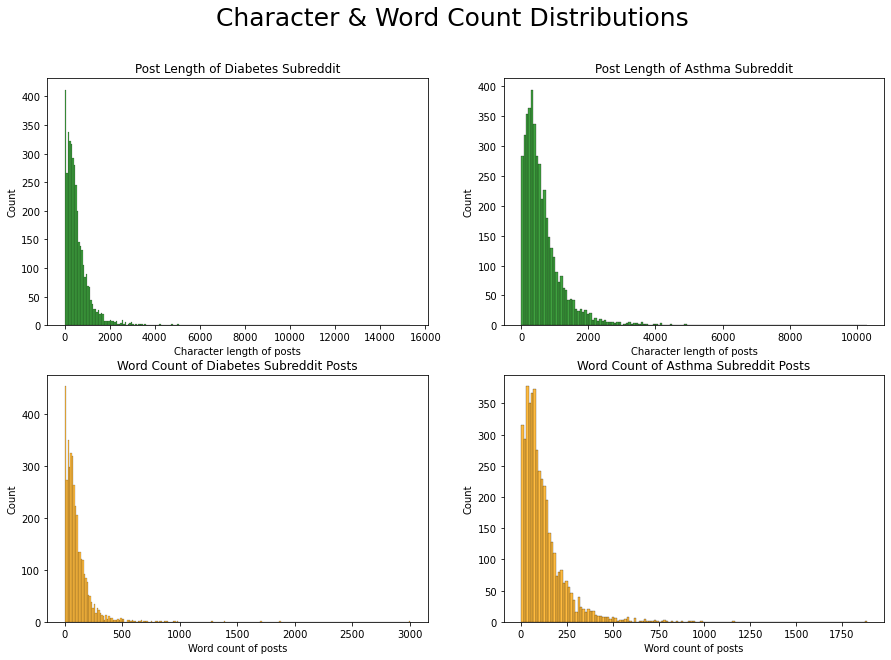

In [58]:
# Character and word count distribution
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(dia['post_length'], ax=ax[0,0], color='green')
sns.histplot(ast['post_length'], ax=ax[0,1], color='green')
sns.histplot(dia['post_word_count'], ax=ax[1,0], color='orange')
sns.histplot(ast['post_word_count'], ax=ax[1,1], color='orange')

ax[0,0].set(xlabel='Character length of posts', title='Post Length of Diabetes Subreddit')
ax[0,1].set(xlabel='Character length of posts', title='Post Length of Asthma Subreddit')
ax[1,0].set(xlabel='Word count of posts', title='Word Count of Diabetes Subreddit Posts')
ax[1,1].set(xlabel='Word count of posts', title='Word Count of Asthma Subreddit Posts')

fig.suptitle('Character & Word Count Distributions', fontsize=25);


Posts from both subreddits have character and word count distributions skewed to the right.

#### Vectorization



In [59]:
# Instantiate CountVectorizer
cv = CountVectorizer(stop_words='english')

# vectorize diabetes selftext column
dia_vec = cv.fit_transform(dia['selftext'])
dia_vec_df = pd.DataFrame(dia_vec.todense(), columns=cv.get_feature_names())

# vectorize asthma selftext column
ast_vec = cv.fit_transform(ast['selftext'])
ast_vec_df = pd.DataFrame(ast_vec.todense(), columns=cv.get_feature_names())

#### Most common words


Text(0.5, 0.98, 'Most common words of each subreddit')

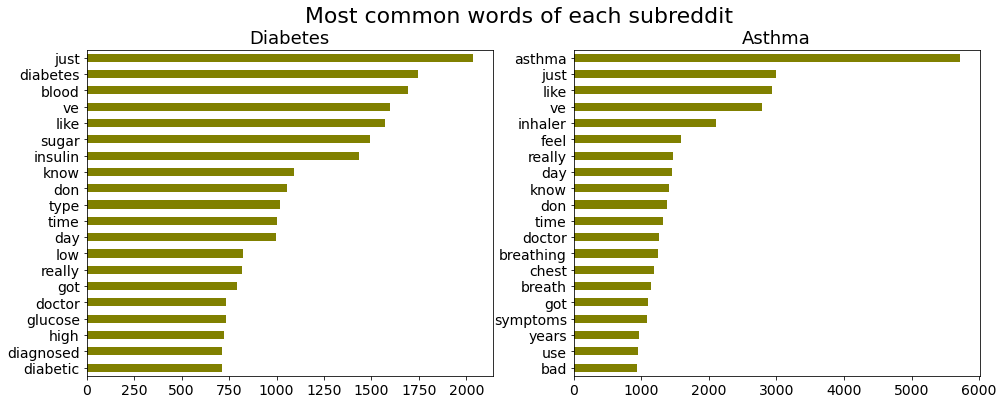

In [60]:
# a plot showing the top 20 words for each subreddit post
fig, ax = plt.subplots(1, 2, figsize=(16,6))
dia_vec_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax[0], color='olive', fontsize=14)
ast_vec_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax[1], color='olive', fontsize=14)

ax[0].set_title('Diabetes', fontsize=18)
ax[1].set_title('Asthma', fontsize=18)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

fig.suptitle('Most common words of each subreddit', fontsize=22)

Out of the top 20 common words in each subreddit, the following words are common across both documents.
- just, 
- ve, 
- like, 
- don, 
- know, 
- time, 
- got, 
- day
- really
- feel
- doctor

These words are important to both documents and so their predictive power is very low. 

## Pre-processing

In [61]:
# concatenate asthma and diabetes df
df= pd.concat([dia[['selftext', 'subreddit']], ast[['selftext', 'subreddit']]], axis=0, ignore_index=True)
df.head()

,selftext,subreddit
0,"Newly diagnosed, history of insulin resistance...",diabetes
1,Diagnosed A1c 6.9% Oct 2019\n\nLab A1c 5.2% Ju...,diabetes
2,My pump was shipped last week Thursday from a ...,diabetes
3,So recently I quit my job because it caused me...,diabetes
4,"Hi\n\nI have prescription for Novolog, dosage ...",diabetes


In [62]:
# number of documents in the corpus
df.shape

(8312, 2)

In [63]:
# categories in the subreddit column
df['subreddit'].unique()

array(['diabetes', 'Asthma'], dtype=object)

In [64]:
# change the labels of categories of subreddit
df['subreddit'] = df['subreddit'].map({'diabetes':1, 'Asthma':0})

In [65]:
df.isnull().sum()

selftext     0
subreddit    0
dtype: int64

#### Define X and y

In [66]:
# create a data series for X and y
X = df['selftext']
y = df['subreddit']

In [67]:
# check baseline accuracy
y.value_counts(normalize=True)

0    0.531039
1    0.468961
Name: subreddit, dtype: float64

Baseline accuracy is 46.9%. If we were to guess that a post came from Diabetes subreddit, we would be right 46.9% of the time.

In [68]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, stratify=y, random_state=42)

## Modeling

### 1. Multinomial NB with CountVectorizer

Multinomial Naive Bayes can be used when our variables are positive integers.

In [69]:
# set a pipeline
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('nb', MultinomialNB())    
])

In [70]:
# set hyperparameters
pipe_params = {
    'cv__max_features': [1000, 2000, 3000, 4000, 5000],
    'cv__min_df': [2, 3, 4],
    'cv__max_df': [0.92, 0.95],
    'cv__ngram_range': [(1,1), (1,2)]
}

In [71]:
# instantiate GridSearchCV
gs = GridSearchCV(
    estimator = pipe,
    param_grid = pipe_params,
    cv = 5,
    n_jobs = -1
)

In [72]:
# fit gridsearch to train data
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cv__max_df': [0.92, 0.95],
                         'cv__max_features': [1000, 2000, 3000, 4000, 5000],
                         'cv__min_df': [2, 3, 4],
                         'cv__ngram_range': [(1, 1), (1, 2)]})

In [73]:
# gridsearch optimization
print('Best score:', gs.best_score_)
print('Best parameters:', gs.best_params_)
print('Accuracy on train data:', gs.score(X_train, y_train))
print('Accuracy on test data:', gs.score(X_test, y_test))

Best score: 0.956185991892777
Best parameters: {'cv__max_df': 0.92, 'cv__max_features': 5000, 'cv__min_df': 4, 'cv__ngram_range': (1, 1)}
Accuracy on train data: 0.9640869096785778
Accuracy on test data: 0.955523149835946


- The best score of the gridsearch from all the different combinations of hyperparameters is an accuracy of 95.6% which is better than the null model with 46.9% accuracy.
- The hyperparameters for the best score are where the top 5,000 words from the entire corpus will be saved, a word must occur in at least 4 documents from the corpus and when we ignore words that occur in > 92% of the documents from the corpus.
- The accuracy of the estimator is more or less the same on our train and test data. Hence, the model is not overfit.

#### Metrics: 

- For the problem we are trying to solve, a prediction that is a false negative will be worse than a false positive.  A patient request diagnosed as asthma and wrongly labeled as a diabetes diagnosis may create an inconvenience for the researchers where they have to review requests diagnosed as asthma which will waste their valuable time.
- But what would be worse is a false negative prediction where researchers lose data on diabetes requests that potentially have valuable information for their research and can be costly in terms of the outcome of their research. Therefore, we will be more interested in sensitivity.
- Sensitivity measures the number of correct predictions out of all the positive predictions. 
- I also looked at accuracy , because accuracy shows a general picture of how the models are performing. 


In [74]:
# make predictions 
y_pred = gs.predict(X_test)

# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

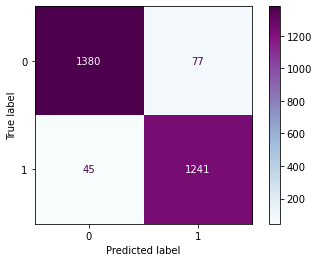

In [75]:
# plot a confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='BuPu', values_format='d');

In [76]:
# sensitivity and accuracy
accu = (tp+tn) / (tp+tn+fp+fn)
sens = tp/(tp+fn)

print('Accuracy:', accu)
print('Sensitivity:', sens)

Accuracy: 0.955523149835946
Sensitivity: 0.9650077760497667


This model has an accuracy of 95.6% which is way better than the null model with 46.9% accuracy. 

### 2. Multinomial NB with TF-IDF Vectorizer

In [77]:
# set a pipeline
pipe_tv = Pipeline([
    ('tv', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [78]:
# set hyperparameters
pipe_params = {
    'tv__max_features': [1000, 2000, 3000, 4000, 5000],
    'tv__stop_words': [None, 'english'],
    'tv__ngram_range': [(1,1), (1,2), (1,3)]
}

In [79]:
# instantiate GridSearchCV
gs_tv = GridSearchCV(
    pipe_tv,
    param_grid = pipe_params,
    cv = 5,
    n_jobs = -1
)

In [80]:
gs_tv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tv', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tv__max_features': [1000, 2000, 3000, 4000, 5000],
                         'tv__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tv__stop_words': [None, 'english']})

In [82]:
# gridsearch optimization
print('best score:', gs_tv.best_score_)
print('best parameters:', gs_tv.best_params_)
print('accuracy on train data:', gs_tv.score(X_train, y_train))
print('accuracy on test data:', gs_tv.score(X_test, y_test))


best score: 0.954209836097306
best parameters: {'tv__max_features': 5000, 'tv__ngram_range': (1, 1), 'tv__stop_words': 'english'}
accuracy on train data: 0.9646256060333992
accuracy on test data: 0.95260663507109


In [83]:
# make predictions
pred_tv = gs_tv.predict(X_test)

# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, pred_tv).ravel()

In [84]:
# sensitivity and accuracy
accu = (tp+tn) / (tp+tn+fp+fn)
sens = tp/(tp+fn)

print('Accuracy:', accu)
print('Sensitivity:', sens)

Accuracy: 0.95260663507109
Sensitivity: 0.9533437013996889


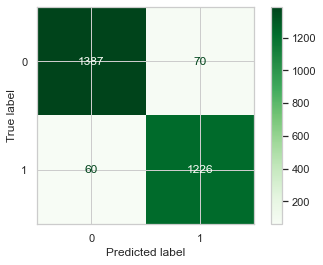

In [1069]:
# plot confusion matrix
plot_confusion_matrix(gs_tv, X_test, y_test, cmap='Greens');

- This model performed more or less the same to the first model interms of accuracy and sensitivity. Sensitivity is less by 1% comparing it to the first model.

- If both of the outcomes of our target are equally important, this model maybe preferred because it has predicted a balanced number of false negatives and false positives, and has a 95% accuracy on the test data. 

### 3. Random Forest Classifier with CountVectorizer 

In [85]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [86]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer(stop_words='english', min_df=4, max_df=.92, max_features= 4000, ngram_range= (1,2))

In [87]:
cvec.fit(X_train)

CountVectorizer(max_df=0.92, max_features=4000, min_df=4, ngram_range=(1, 2),
                stop_words='english')

In [88]:
# Transform train
X_train = cvec.transform(X_train)

In [89]:
# Transform test
X_test = cvec.transform(X_test)

In [90]:
# Instantiate RandomForestClassifier
rf = RandomForestClassifier()

In [91]:
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.9473851543937245

In [92]:
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'max_features': ['sqrt', .5]
}

gs_rf = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5],
                         'max_features': ['sqrt', 0.5],
                         'n_estimators': [100, 150, 200]},
             verbose=1)

In [93]:
# gridsearch optimization
print('best score:', gs_rf.best_score_)
print('best parameters:', gs_rf.best_params_)
print('accuracy on train data:', gs_rf.score(X_train, y_train))
print('accuracy on test data:', gs_rf.score(X_test, y_test))

best score: 0.9488212587972082
best parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
accuracy on train data: 0.9856347638714311
accuracy on test data: 0.95260663507109


In [94]:
# make predictions
pred_rf = gs_rf.predict(X_test)

# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, pred_rf).ravel()

In [95]:
# sensitivity and accuracy
accu = (tp+tn) / (tp+tn+fp+fn)
sens = tp/(tp+fn)

print('Accuracy:', accu)
print('Sensitivity:', sens)

Accuracy: 0.95260663507109
Sensitivity: 0.9751166407465007


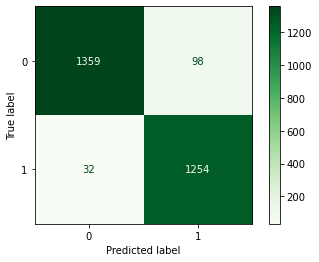

In [96]:
plot_confusion_matrix(gs_rf, X_test, y_test, cmap='Greens');

In [1142]:
# get feature importances
importances= gs_rf.best_estimator_.feature_importances_

In [1143]:
# get feature names
names=cvec.get_feature_names()

In [1144]:
# creates the feature importance dataframe
importance_dict = pd.DataFrame({'feature_importance': importances,
                                'features': names})
top10 = importance_dict.nlargest(10, columns=['feature_importance'])
top10

,feature_importance,features
345,0.116981,asthma
1862,0.042034,inhaler
994,0.041308,diabetes
1897,0.028943,insulin
3343,0.021768,sugar
556,0.020404,breathing
1001,0.018593,diabetic
494,0.017025,blood
544,0.015591,breath
682,0.014694,chest


Random forest classifier performed better comparing it to the previous two models interms of sensitivity. 

## 4. Knn classifier with Tf-IDF Vectorizer

In [98]:
# create a data series for x and y
X = df['selftext']
y = df['subreddit']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [100]:
# Instantiate pipeline object.
pipe_knn = Pipeline([
    ('tfv', TfidfVectorizer()),
    ('sc', StandardScaler()),
    ('knn', KNeighborsClassifier())
])


In [101]:
# Define dictionary of hyperparameters.
pipe_knn_params = {
    'tfv__stop_words': [None, 'english'],
    'tfv__ngram_range': [(1,1), (1,2)],
    'sc__with_mean': [False],
    'knn__p': [1,2],
    'knn__weights': ['uniform', 'distance'],
    'knn__n_neighbors': [3, 5, 10]
}

In [102]:
# Instantiate our GridSearchCV object.
gs_knn = GridSearchCV(pipe_knn,
                                 pipe_knn_params,
                                 n_jobs=-1,
                                 verbose=1)

In [103]:
# Fit the GridSearchCV object to the data.
gs_knn.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(estimator=Pipeline(steps=[('tfv', TfidfVectorizer()),
                                       ('sc', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 10], 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance'],
                         'sc__with_mean': [False],
                         'tfv__ngram_range': [(1, 1), (1, 2)],
                         'tfv__stop_words': [None, 'english']},
             verbose=1)

In [104]:
# gridsearch optimization
print('best score:', gs_knn.best_score_)
print('best parameters:', gs_knn.best_params_)
print('accuracy on train data:', gs_knn.score(X_train, y_train))
print('accuracy on test data:', gs_knn.score(X_test, y_test))

best score: 0.5566283639321853
best parameters: {'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'distance', 'sc__with_mean': False, 'tfv__ngram_range': (1, 1), 'tfv__stop_words': None}
accuracy on train data: 0.9858838626884825
accuracy on test data: 0.5726660250240616


In [105]:
# make predictions
pred_knn = gs_knn.predict(X_test)

# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, pred_knn).ravel()

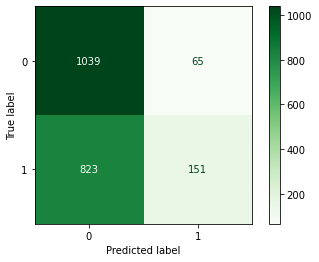

In [106]:
plot_confusion_matrix(gs_knn, X_test, y_test, cmap='Greens');

In [107]:
# sensitivity and accuracy
accu = (tp+tn) / (tp+tn+fp+fn)
sens = tp/(tp+fn)

print('Accuracy:', accu)
print('Sensitivity:', sens)

Accuracy: 0.5726660250240616
Sensitivity: 0.15503080082135523


Knn classifier performed the worst comparing it to the above models with a sensitivity of 15.5% and 57.3%

## Conclusions

- The best classifier is found to be the multinomial Naive Bayes (with countvectorizer) with an accuracy of 95.6% and sensitivity of 97.2%. 
- This model is performing very well, but it would be a good idea to make sure that we are not training the estimator obvious words such as asthma and diabetes which are in the top common words. 
- Also, including more stop words into the English stop words that are common across each subreddit such as 'doctor', 'like', and 'just', might help to increase the performance of the classfier. 
- Knn classifer has a sensitivty of 15.5%. This is very low comparing it with how the other models performed. Analyzing why there are many false positive predictions with the knn classifier will help to identify trends in the data. 